In [90]:
import ipywidgets as widgets

path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3S_S08_2um.tiff',
    placeholder='Type something',
    description='File path:',
    disabled=False
)

display(path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\Fe3S_S08_2um.tiff', description='Fil…

In [91]:
%matplotlib inline
import ipyvolume as ipv
import matplotlib.pyplot as plt
from skimage import data, io, filters
import numpy as np

from skimage import data, io, filters
## C:\Users\inst\SynologyDrive\Master\Exp\Hi-am\data\2019-04-10 - Issa - Fe3Si -S08 (unlabelled, green)_2um scan_recon.tiff
stack = io.imread(path.value).T


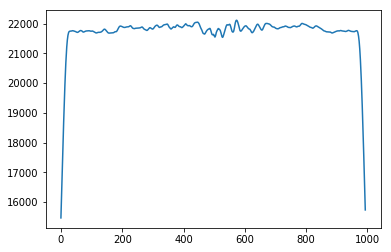

In [92]:
mean_z_intensity = np.mean(stack, axis = (0,1))

fig, ax = plt.subplots()
ax.plot(range(mean_z_intensity.shape[0]), mean_z_intensity)
plt.show()

In [93]:
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

cpt = importr('changepoint')

cpm_result = cpt.multiple_mean_norm(FloatVector(mean_z_intensity),"BinSeg","MBIC",0,2,True,True,1)

change_pts = cpt.cpts(cpm_result)

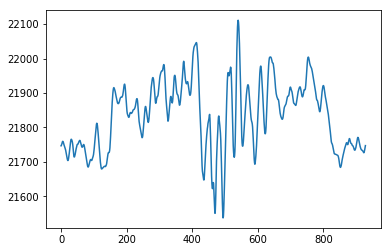

In [94]:
bot = int(change_pts[0])+20
top = int(change_pts[1])-20
cut_warp = mean_z_intensity[bot:top]

fig, ax = plt.subplots()
ax.plot(range(cut_warp.shape[0]), cut_warp)
plt.show()

(-0.5, 1012.5, 991.5, -0.5)

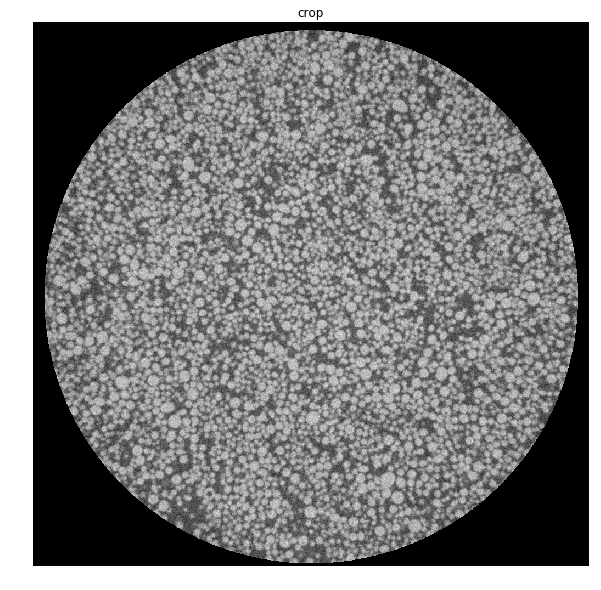

In [95]:
cropped = stack[:,:,bot:top]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cropped[:,:,100], cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('crop')
ax.axis('off')

In [96]:
cleaned = cropped[:,:,100]

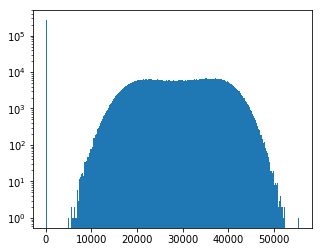

In [97]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.ravel(cleaned), bins=256)
ax.set_yscale("log", nonposy='clip')


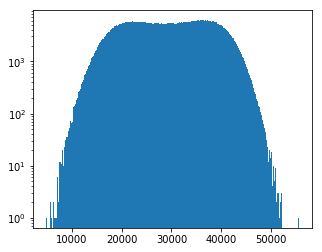

In [98]:
import kmean.k as kk
from sklearn.mixture import GaussianMixture
import numpy.ma as ma

flat = np.ravel(cleaned)
masked = ma.masked_where(flat == 0, flat)

fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(masked.compressed(), bins=256)
ax.set_yscale("log", nonposy='clip')


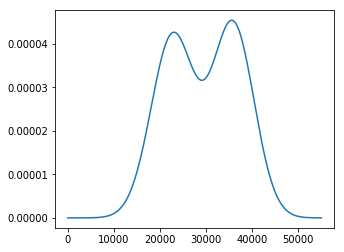

In [99]:
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(masked.compressed().reshape(-1,1))

x = np.linspace(0,55000,50000)
y = np.exp(clf.score_samples(x.reshape(-1,1)))

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(x,y)

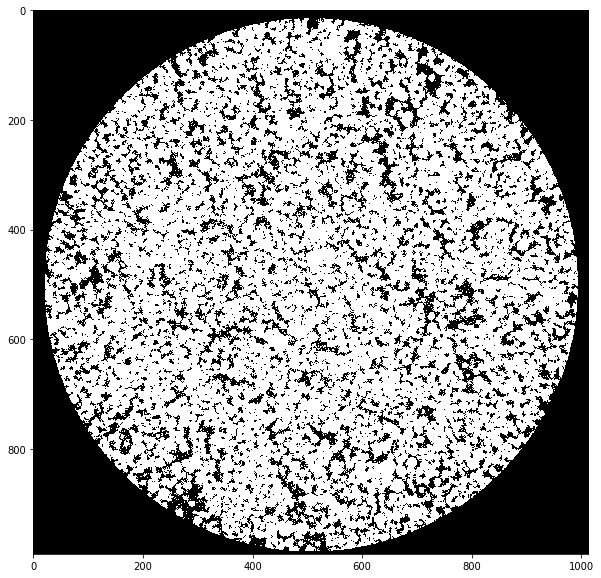

In [100]:

top_peak_i = np.argmax(clf.means_)
top_peak_var = np.ravel(clf.covariances_)[top_peak_i]
top_peak_mean = np.ravel(clf.means_)[top_peak_i]

thres_im = np.copy(cleaned)
bot_thres = (top_peak_mean - 3*top_peak_var**0.5)
top_thres = (top_peak_mean + 3*top_peak_var**0.5)

band = np.logical_and(bot_thres < cleaned,cleaned < top_thres)

thres_im[band] = 1.0
thres_im[~band] = 0.0

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(thres_im, cmap='gray')


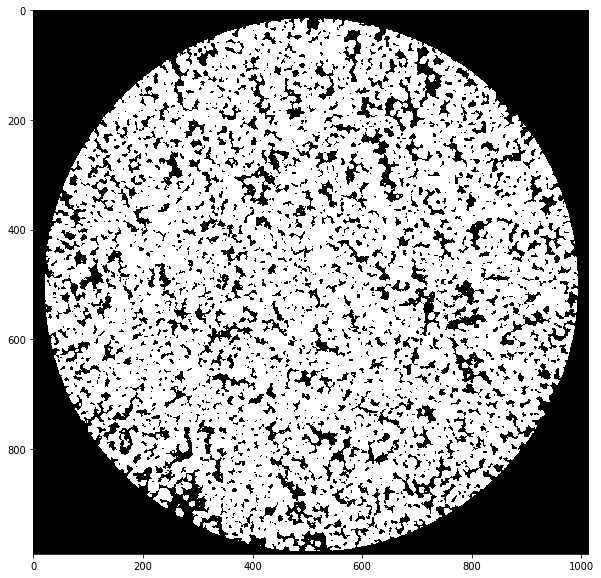

In [101]:
import scipy.ndimage as spim
from skimage.filters import median

cl_thres = median(thres_im)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cl_thres, cmap='gray')
